In [1]:
import tensorflow as tf
import numpy as np
import gym
import time
import matplotlib.pyplot as plt

2024-12-20 09:55:54.609271: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 09:55:54.619940: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 09:55:54.649692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734688554.692947  148738 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734688554.707803  148738 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 09:55:54.767426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
env = gym.make("CartPole-v1")

In [3]:
EPISODES = 2000
GAMMA = 0.99
LR = 0.0003
BATCH_SIZE = 64
UPDATE_STEPS = 10
EPSILON = 0.2
VALUE_LOSS_WEIGHT = 0.5
ENTROPY_WEIGHT = 0.01

In [4]:
class PPOModel(tf.keras.Model):
    def __init__(self):
        super(PPOModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation="relu")
        self.dense2 = tf.keras.layers.Dense(128, activation="relu")
        self.policy_logits = tf.keras.layers.Dense(env.action_space.n)
        self.value = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        logits = self.policy_logits(x)
        value = self.value(x)
        return logits, value

In [5]:
model = PPOModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

2024-12-20 09:56:03.526207: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
start_time = time.time()

reward_list = []
for episode in range(EPISODES):
    state = env.reset()[0]
    done = False
    total_reward = 0
    states = []
    actions = []
    rewards = []
    dones = []
    old_log_probs = []
    
    while not done:
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, 0)
        
        logits, value = model(state_tensor)
        prob = tf.nn.softmax(logits)
        
        dist = tf.random.categorical(logits, 1)
        action = dist.numpy()[0][0]
        log_prob = tf.math.log(prob[0, action])
        
        next_state, reward, done, _, _ = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        old_log_probs.append(log_prob)
        
        state = next_state
        total_reward += reward
    
    discounted_rewards = []
    discounted_reward = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        if done:
            discounted_reward = 0
        discounted_reward = reward + GAMMA * discounted_reward
        discounted_rewards.insert(0, discounted_reward)

    states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
    old_values = model(states_tensor)[1]
    advantages = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32) - old_values.numpy().flatten()

    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    old_log_probs = tf.convert_to_tensor(old_log_probs, dtype=tf.float32)
    discounted_rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)
    advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)

    with tf.GradientTape() as tape:
        logits, value = model(states_tensor)
        prob = tf.nn.softmax(logits)
        dist = tf.random.categorical(logits, 1)
        log_prob = tf.math.log(tf.gather(prob, actions, axis=1, batch_dims=1))

        ratio = tf.exp(log_prob - old_log_probs)
        clipped_ratio = tf.clip_by_value(ratio, 1 - EPSILON, 1 + EPSILON)

        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
        value_loss = tf.reduce_mean(tf.square(discounted_rewards - value))
        entropy_loss = -tf.reduce_mean(prob * tf.math.log(prob))

        loss = policy_loss + VALUE_LOSS_WEIGHT * value_loss - ENTROPY_WEIGHT * entropy_loss

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if episode % 10 == 0:
        current_time = time.time()
        elapsed_time = current_time - start_time
        print(f"Episode {episode}, Total Reward: {total_reward}, Time: {elapsed_time:.2f} seconds")

    reward_list.append(total_reward)

end_time = time.time()

training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")



/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: 11.0, Time: 1.23 seconds
Episode 10, Total Reward: 10.0, Time: 4.40 seconds
Episode 20, Total Reward: 12.0, Time: 6.73 seconds
Episode 30, Total Reward: 20.0, Time: 9.13 seconds
Episode 40, Total Reward: 20.0, Time: 12.26 seconds
Episode 50, Total Reward: 28.0, Time: 14.84 seconds
Episode 60, Total Reward: 19.0, Time: 18.10 seconds
Episode 70, Total Reward: 15.0, Time: 20.43 seconds
Episode 80, Total Reward: 16.0, Time: 22.91 seconds
Episode 90, Total Reward: 33.0, Time: 25.69 seconds
Episode 100, Total Reward: 13.0, Time: 27.99 seconds
Episode 110, Total Reward: 20.0, Time: 30.52 seconds
Episode 120, Total Reward: 48.0, Time: 33.25 seconds
Episode 130, Total Reward: 29.0, Time: 36.29 seconds
Episode 140, Total Reward: 15.0, Time: 38.91 seconds
Episode 150, Total Reward: 13.0, Time: 42.65 seconds
Episode 160, Total Reward: 25.0, Time: 45.21 seconds
Episode 170, Total Reward: 16.0, Time: 48.26 seconds
Episode 180, Total Reward: 24.0, Time: 51.15 seconds
Episode 

Episode 1500, Total Reward: 461.0, Time: 1582.67 seconds
Episode 1510, Total Reward: 353.0, Time: 1602.01 seconds
Episode 1520, Total Reward: 524.0, Time: 1624.39 seconds
Episode 1530, Total Reward: 216.0, Time: 1645.66 seconds
Episode 1540, Total Reward: 286.0, Time: 1665.69 seconds
Episode 1550, Total Reward: 163.0, Time: 1688.81 seconds
Episode 1560, Total Reward: 309.0, Time: 1712.37 seconds
Episode 1570, Total Reward: 170.0, Time: 1733.39 seconds
Episode 1580, Total Reward: 122.0, Time: 1756.18 seconds
Episode 1590, Total Reward: 427.0, Time: 1781.92 seconds
Episode 1600, Total Reward: 135.0, Time: 1810.49 seconds
Episode 1610, Total Reward: 405.0, Time: 1832.72 seconds
Episode 1620, Total Reward: 121.0, Time: 1849.92 seconds
Episode 1630, Total Reward: 182.0, Time: 1868.66 seconds
Episode 1640, Total Reward: 143.0, Time: 1886.73 seconds
Episode 1650, Total Reward: 362.0, Time: 1914.85 seconds
Episode 1660, Total Reward: 161.0, Time: 1938.08 seconds
Episode 1670, Total Reward: 186

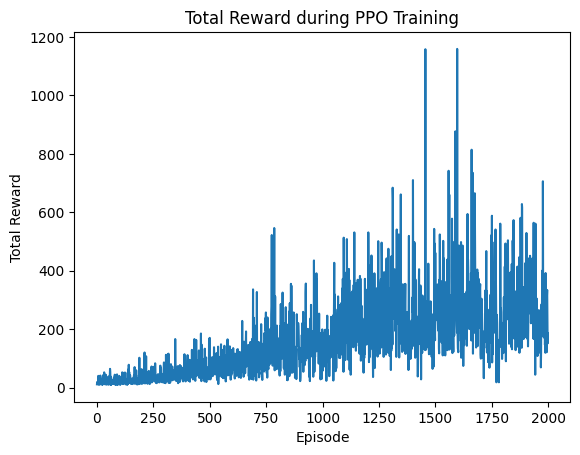

In [8]:
plt.plot(reward_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward during PPO Training')
plt.show()